# EcoDynElec - Enr Model example

This project aims to simulate the solar and wind electricity production based on real years, using machine learning algorithms.
This notebook shows an example of the generation of 2017-2019 production data from 2020-2022 real data.

It has two parts : model input data generation, and data generation using the model.

In [8]:
# autorelead
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd

from ecodynelec_enr_model import data_loading
from ecodynelec_enr_model.data_model import generate_production_files, wind_plants_model, solar_plants_model
from ecodynelec_enr_model.data_model import load_expected_result
from ecodynelec_enr_model.data_utils import plot_predictions, compare_plot_predictions, get_correlation_results

# If you want to use another input/output folder, edit this line
#data_loading.root_dir = './ecd_enr_model/'

### 1. Model input generation

Model input data is generated using the ERA5 meteorogical data (https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.4bd77450?tab=form).
A folder must be created for each indicator for each year, containing the 12 (or one) .cdf files of this year. Example for the solar_plants_model, we have solar_radiation_2017, ..., solar_radiation_2022 and 2m_temperature_2017, ..., 2m_temperature_2022.

Then a folder prod_year must be created for each training year (prod_2020, prod_2021, prod_2022) containing the Pronovo's production data for this year, and a file EC_Solar_Daily_Prod_year with the daily solar production from EnergyCharts.

The model input data will be exported in generated_wind and generated_solar folders, which must be created before running the script.

In [ ]:
# Run this to generate the model input data before generating the power production profiles
generate_learning_model_input = True

### 2. Model input loading

This step of generating the model input data can be quite long, and requires a bunch of RAM, so if you already have the generated input data, this step can be skipped.
The model input must be in generated_wind/generated_solar folders.

In [ ]:
# Run this if you already generated the power production data
generate_learning_model_input = False

### 3. Predicting the renewable electricity production

We can now predict the electricity production from 2017 to 2019, all you have to do is running this line and wait (it can be quite long if generate_learning_model_input is True).
The output data will automatically be saved in a 'ecd_enr_model/export/enr_all_prod_2017-2022.csv' file.

In [ ]:
enr_data = generate_production_files([wind_plants_model, solar_plants_model], [2020, 2021, 2022], [2016, 2017, 2018, 2019],
                                     'enr_all_prod_2016-2019.csv',
                                     generate_learning_model_input=generate_learning_model_input, verbose=False)

### 4. Visualise and validate the generated data

In [10]:
# Load the generated data
enr_prod_all = pd.read_csv(f'{data_loading.root_dir}export/enr_prod_2017-2022.csv', index_col=0, parse_dates=[0])

In [11]:
enr_prod_all.head(5)

,Wind,Solar
2017-01-01 00:00:00,14634.896963,26.785540
2017-01-01 01:00:00,12113.685527,62.300527
2017-01-01 02:00:00,9585.733589,57.716217
2017-01-01 03:00:00,7281.099082,47.506732
2017-01-01 04:00:00,6790.283605,40.850884


In [12]:
enr_prod_all.tail(5)

,Wind,Solar
2022-12-31 19:00:00,52294.425,378.138052
2022-12-31 20:00:00,51756.704,293.560887
2022-12-31 21:00:00,56297.081,233.298375
2022-12-31 22:00:00,54254.986,184.693756
2022-12-31 23:00:00,49216.831,176.632548


Validate the training quality

Load 2022...


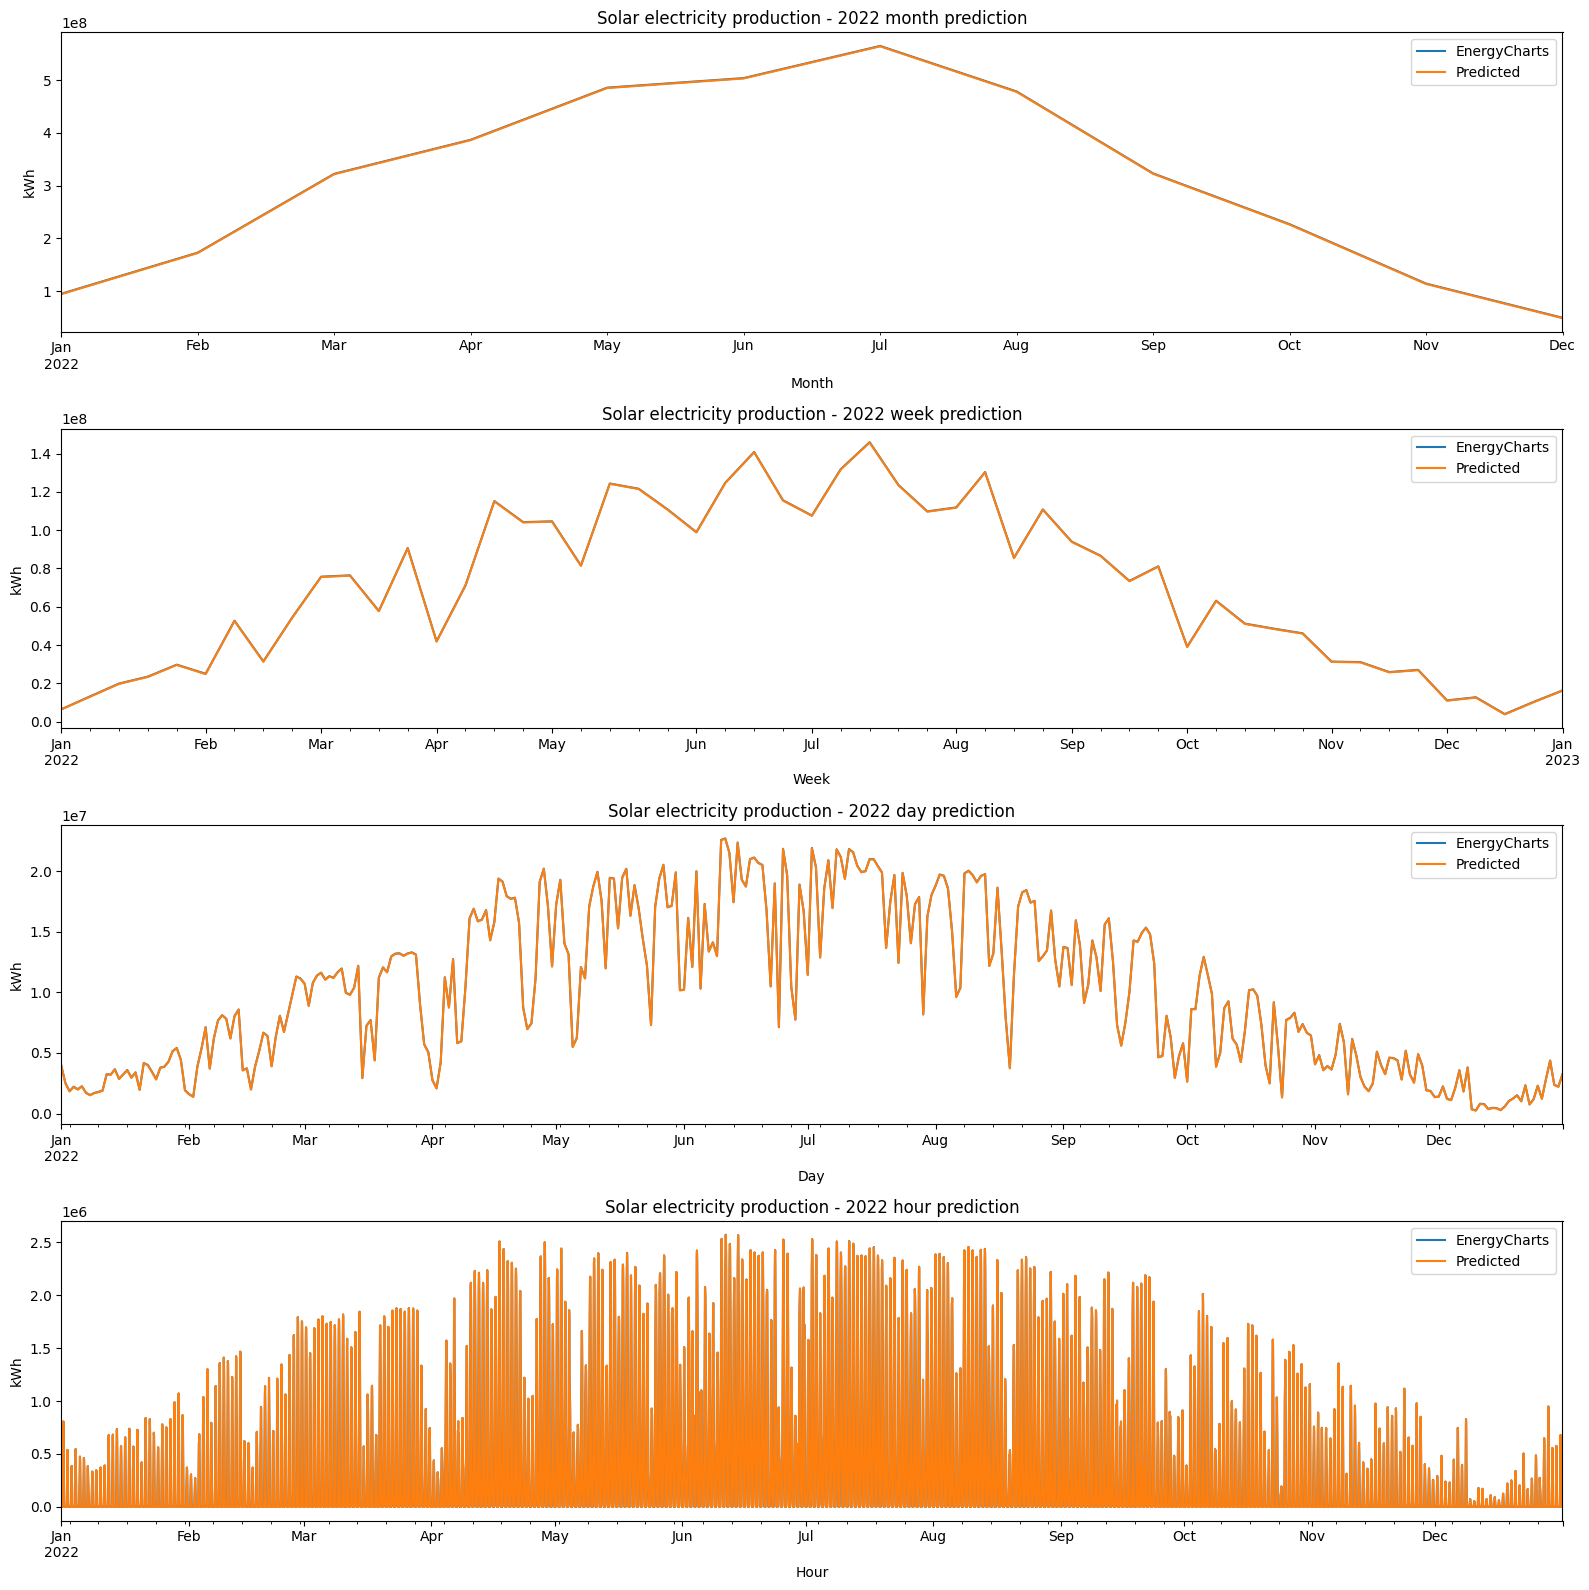

In [20]:
y_true_2022 = load_expected_result(solar_plants_model, [2022], generate_output=False)
plot_predictions(y_true_2022 + 1000, enr_prod_all.loc['2022', 'Solar'], date_label='2022', title="Solar",
                 actual_series_label='EnergyCharts')

Validate the prediction quality with IEA's monthly data

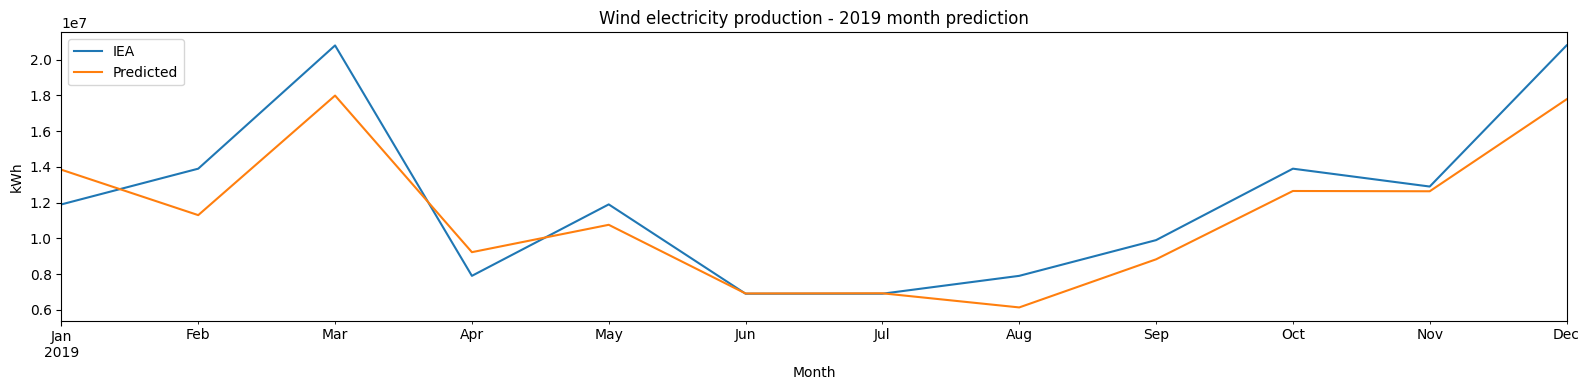

In [14]:
# Wind

iea_monthly_2019 = [11.9, 13.9, 20.8, 7.9, 11.9, 6.9, 6.9, 7.9, 9.9, 13.9, 12.9, 20.8]
y_pred_series3 = enr_prod_all.loc['2019', 'Wind']

iea_monthly_2019 = pd.Series(index=y_pred_series3.resample('M').sum().index, data=iea_monthly_2019) * 1000000

compare_to_series = {
    'IEA': iea_monthly_2019,
    #'EnergyCharts': ec_data.loc['2019'].resample('M').sum() * 1000000
}
compare_plot_predictions(compare_to_series, y_pred_series3.resample('M').sum(), date_label='2019', scale=5,
                         title="Wind")

In [15]:
get_correlation_results(iea_monthly_2019, y_pred_series3)

Actual sum             1.456000e+08
Predicted              1.349786e+08
Diff (%)              -7.294909e+00
Monthly correlation    9.533696e-01
Weekly correlation    -1.064192e-01
Daily correlation     -4.877065e-02
Hourly correlation    -1.514150e-01
dtype: float64

In [16]:
y_pred_series3_m = y_pred_series3.resample('M').sum()
print('Delta MWh', (y_pred_series3_m - iea_monthly_2019) / 1000)
print('Delta (%)', (y_pred_series3_m - iea_monthly_2019) / (iea_monthly_2019) * 100)

Delta MWh 2019-01-31    1941.235767
2019-02-28   -2600.846957
2019-03-31   -2807.231107
2019-04-30    1325.511802
2019-05-31   -1142.273367
2019-06-30      12.651215
2019-07-31      23.348590
2019-08-31   -1767.924728
2019-09-30   -1074.692954
2019-10-31   -1249.198406
2019-11-30    -264.850075
2019-12-31   -3017.116726
Freq: M, dtype: float64
Delta (%) 2019-01-31    16.312906
2019-02-28   -18.711129
2019-03-31   -13.496303
2019-04-30    16.778630
2019-05-31    -9.598936
2019-06-30     0.183351
2019-07-31     0.338385
2019-08-31   -22.378794
2019-09-30   -10.855484
2019-10-31    -8.987039
2019-11-30    -2.053101
2019-12-31   -14.505369
Freq: M, dtype: float64


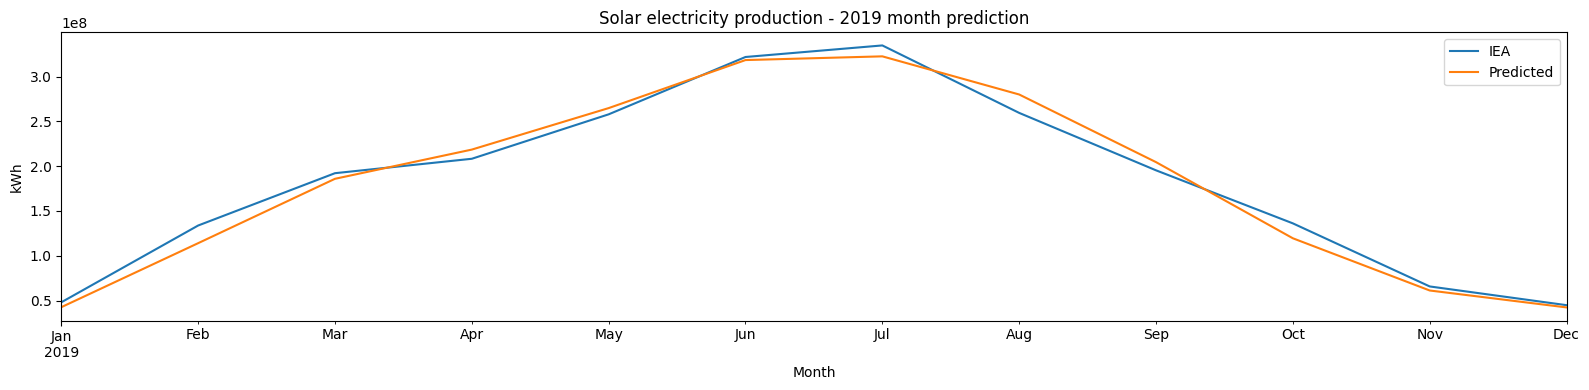

In [17]:
# Solar

iea_monthly_2019 = [48, 133.7, 192.1, 208.2, 257.8, 321.8, 334.7, 259.4, 195.3, 136.1, 65.7, 44.8]
y_pred_series3 = enr_prod_all.loc['2019', 'Solar']

iea_monthly_2019 = pd.Series(index=y_pred_series3.resample('M').sum().index, data=iea_monthly_2019) * 1000000

compare_to_series = {
    'IEA': iea_monthly_2019,
    #'EnergyCharts': ec_data.loc['2019'].resample('M').sum() * 1000000
}
compare_plot_predictions(compare_to_series, y_pred_series3.resample('M').sum(), date_label='2019', scale=5,
                         title="Solar")

In [18]:
get_correlation_results(iea_monthly_2019, y_pred_series3)

Actual sum             2.197600e+09
Predicted              2.173757e+09
Diff (%)              -1.084970e+00
Monthly correlation    9.939795e-01
Weekly correlation     2.791334e-01
Daily correlation      8.052904e-02
Hourly correlation     2.529476e-01
dtype: float64

In [19]:
y_pred_series3_m = y_pred_series3.resample('M').sum()
print('Delta MWh', (y_pred_series3_m - iea_monthly_2019) / 1000)
print('Delta (%)', (y_pred_series3_m - iea_monthly_2019) / (iea_monthly_2019) * 100)

Delta MWh 2019-01-31    -5459.769420
2019-02-28   -19712.844152
2019-03-31    -6262.235887
2019-04-30    10253.700792
2019-05-31     6960.035780
2019-06-30    -3440.399926
2019-07-31   -12182.252020
2019-08-31    20534.068206
2019-09-30     9139.757253
2019-10-31   -16642.859170
2019-11-30    -4519.006156
2019-12-31    -2511.492188
Freq: M, dtype: float64
Delta (%) 2019-01-31   -11.374520
2019-02-28   -14.744087
2019-03-31    -3.259883
2019-04-30     4.924928
2019-05-31     2.699781
2019-06-30    -1.069111
2019-07-31    -3.639753
2019-08-31     7.915986
2019-09-30     4.679855
2019-10-31   -12.228405
2019-11-30    -6.878244
2019-12-31    -5.606009
Freq: M, dtype: float64
